# Text Processing in Python and the use $k$NN methods and Sparse arrays

## Overview 

In the previous notebooks we have seen examples of machine learning on text data. The spam filter and the example about determining whether a news article is about election politics or not, were two instances. In these examples we used a very simple model called *Bag-Of-Words* approach: We identified a subset of *keywords* which we believed are informative in determining the class of document we are looking at (spam or no-spam, and about elections or not about election.) The bag-of-words approach creates binary features for each word with only two values: zero (word not in document) and one (word in document.)

There are more sophisticated methods of encoding information about text data. We can expand the bag-of-words approach in a few ways. First notice that we assume our raw data consists of many documents (say hundreds, thousands, or even millions of text data each represented, for instance, a string.) For supervised learning each document is labeled (for instance, spam or no-spam for email documents, or categories such as "sports", "domestic politics", "international affairs", etc. for classifying news articles.) Then, a preprocessing stage can create some useful information about each document and each keyword:

1) The first useful information is for each word $w$ and each document (string) $D$ we compute the *frequency* of $w$ in $D$. This measure is called *term frequency* and is written as $\text{TF}(w,D)$:
   $$
        \text{TF}(w,D) = \frac{\text{number of times $w$ occurs in $D$}}{\text{Total number of words in $D$}}
   $$
   This quantity is, in fact what is reported in the `Spambase` dataset we used earlier, and we will use again below. The problem with $\text{TF}(w,D)$ function is that it will give a high value to common words such as 'the', 'a', 'is' etc. 
2) Another information is to look at the entire set of documents set $C$ (sometimes called the *corpus*) and for each word see in how many documents it shows up. The idea is to weight down those words (like 'the', 'a', 'is' etc.) that appear in a lot of documents. This measure is called  *Inverse Document Frequencey* $\text{IDF}(w, C)$ where $C$ the corpus is the set of documents in our dataset: $C=\{D_1,\dots,D_N\}$. Inverse document frequency is defined as follows:
   $$
    \text{IDF}(w,C) = 1 + \log \frac{\text{Total number of documents in $C$}}{\text{Number of docunments in $C$ that contain $w$}}
   $$
   Here if "number of documents in $C$ that contain $w$" is small the TDI score goes up. The number 1 is added to guard against TDI becoming zero. This would happen if a a word appears in all documents in the dataset. 
   Suppose, for example, that we wish to decide whether a news article is about American football, or international affairs, or US economy. The word 'touchdown' will probably appear in articles about American football but hardly ever would you see it in articles about US economy or international affairs. Or the term 'geopolitics' may show up in some articles about international affairs, but hardly ever in articles about American football.  $\text{IDF}(w, C)$ intends to reward such words since they do not show up in many documents, they are in a senses, special and can signal what category the article belongs to. The problem with IDF is that it may also give a large value to some rare words that pop up in some document without having much informative power. For example, a rare word such 'anathema' may appear once in an article, but does not give information about football or international affair or US economy. Nevertheless, IDF would give it a high score.
3) Since the term frequency TF and the inverse document frequency IDF act in opposite direction, their product could simultaneously reward words that appear only in some documents, but when they appear in those documents, they do so by a lot. By multiplying TF and IDF we increase the score of such words which have a potential to be informative:
   $$
    TFIDF(w,D) = Tf(w,D) \times IDF(w,C)
   $$

One thing to pay attention to is that for each term $w$,  TF$(w,D)$ depends on a particular document $D$ while TDI$(w,C)$ is property of the entire dataset of documents and is independent of the special document. So, in effect the TF-IDF multiplies the term frequency by a constant dependent on the term $w$ and not the  document $D$.

## More preprocessing of text data
There are many other activities take place in text processing:

1) All cases are usually turned into lower case or upper case.
2) Common words such as 'the', 'a', 'is', 'in', 'on' etc. are removed from the document.
3) Sometimes numbers are are also removed from the document.
4) Variations of words are 'tokenized' into one. For example, 'go', 'gone', 'going', 'went' are all reduced to a single token and considered the same word.
5) Punctuation symbols are often removed.

While theses removals and transformations are useful most of the time, they are not always helpful and sometimes could cause valuable information to get lost. For instance, in a project that wishes to analyze sentiment in post on X, some people show their anger by using all capital letters, or multiple exclamation marks like '!!!'. Or in a business related document removing 100 from the sentence: "Google plans to invest 100 billion dollars in generative AI" will lose potentially important information, depending on what we plan to do. Even common words like 'the' or 'on' etc. may for some tasks be useful. So caution should be exercised in removing stop words and symbols. It is a decision that is based on the dataset and the task we are planning to accomplish.

## a simple example "by hand"

The Python module `sklearn' has a number of good utilities for text processing tasks. But first, let us do a simple example. 

Suppose our dataset has the following three documents:

- "Beethoven's piano concertos revolutionized the art of concertos for ever."
- "Duke Ellington was a great jazz pianist and also had enormous success as a jazz orchestra leader of his time."
- "The Beatles were the most successful band from England in the sixties. Their music lives on for ever."

Let us do some processing and compute the TF, and IDF values:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay,roc_auc_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [6]:
C = ["Beethoven's piano concertos revolutionized the art of concertos for ever.",
  "Duke Ellington was a great jazz pianist and also had enormous success as a great jazz orchestra leader of his time.",
  "The Beatles were the most successful and the greatest band from England in the sixties. Their music lives on for ever."]

#remove punctuation:
for c in ["'",'.']:
    C=[d.replace(c, "") for d in C]

# Turn to lower case:
C=[d.lower() for d in C]
print('after removing punctuation and turning all letters to lower case:')
_=[print('\n'+c) for c in C]

# Create a list of "stop words" that are common and not useful and remove them from all documents
stopwords=[" a ", " for ", " the ", "the ", " of ", " was ", " and ", " were ", " from ", " in ", " their ", " on ", " for ", " as "]
for st in stopwords:
    C=[d.replace(st, " ") for d in C]

print("after removing stop words:")
_=[print('\n'+c) for c in C]

# Create tokens and collapse related words to their token:
tokens=dict(zip(["pianist", "successful", "greatest"],["piano","success","great"]))
 
for item in list(tokens):
    C=[c.replace(item,tokens[item]) for c in C]

print("after reducing all variants of a word to its common form:")
_=[print('\n'+c) for c in C]

after removing punctuation and turning all letters to lower case:

beethovens piano concertos revolutionized the art of concertos for ever

duke ellington was a great jazz pianist and also had enormous success as a great jazz orchestra leader of his time

the beatles were the most successful and the greatest band from england in the sixties their music lives on for ever
after removing stop words:

beethovens piano concertos revolutionized art concertos ever

duke ellington great jazz pianist also had enormous success great jazz orchestra leader his time

 beatles most successful greatest band england sixties music lives ever
after reducing all variants of a word to its common form:

beethovens piano concertos revolutionized art concertos ever

duke ellington great jazz piano also had enormous success great jazz orchestra leader his time

 beatles most success great band england sixties music lives ever


## Computing TF as a data frame
Below we define a function that takes a list of strings (documents) and returns a Pandas data frame where the $d,w$ entry is the TF$(w,d)$

In [9]:
def termFreq(docList):
    """
    Find frequency of occurrence of each word in the list of documents docList
    return in the form of data frame, columns are the set of all words appearing in all documents
    rows are for each document
    each  entry of the data frame contains the TF-IDF score of the word in column in the document in row
    """
    import pandas as pd
    from functools import reduce # reduce is like sum over a list, except accepts any binary function and applies to a list

    wordSets=[set(d.split()) for d in docList] # get the set of words in each document
    U=reduce(lambda x,y: x.union(y), wordSets) # union all sets into one, so U is the set of all words appearing in all docs
    U=list(U)
    U.sort()
    # Create a dictionary where for each word
    dictList=[]
    for wordList in docList:
        n=len(set(wordList.split(' ')))
        freqs=[wordList.count(c)/n for c in U]
        dictList=dictList + [dict(zip(U,freqs))]

    return pd.DataFrame(dictList)

tfDf=termFreq(C)
display(tfDf)


,also,art,band,beatles,beethovens,concertos,duke,ellington,england,enormous,...,leader,lives,most,music,orchestra,piano,revolutionized,sixties,success,time
0,0.000000,0.166667,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000
1,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.076923,...,0.076923,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923
2,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.090909,0.090909,0.090909,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000


## Computing the IDF and the TFIDF 
Once the TF is calculated computing both IDF and TFIDF are one-line functions which we define using lambda functions.

Notice that even for our small set of three documents, each a sentence or two, the corresponding TF and IDF data frames have a lot of zero entries. Imagine now a large collection of documents, each containing hundreds of words or more. Then the TF and IDF tables are huge with a very large number of zeros. For such cases, it is more practical to use *sparse matrix* representation. Such sparse representations simply contain a list of (word, document, value) triplets where the values (TF or TFIDF) are nonzero. The `sklearn` module `TfidfVectorizer()` performs this task. We discuss this module later in this notebook.

In [13]:
# Compute idf which is a vector the same length as the list of of wirds
idf = lambda tfDf: 1+np.log(len(tfDf)/np.array([sum(tfDf[c]>0) for c in tfDf.columns]))

# Compute tfidf table by multiplying values of idf to the corresponding columns of tfDf:
tfidf = lambda tfDf: tfDf * idf(tfDf)

print(f"{idf(tfDf)=}")
print("\nTFIDF table:\n")
display(tfidf(tfDf))


idf(tfDf)=array([2.09861229, 2.09861229, 2.09861229, 2.09861229, 2.09861229,
       2.09861229, 2.09861229, 2.09861229, 2.09861229, 2.09861229,
       1.40546511, 1.40546511, 2.09861229, 2.09861229, 2.09861229,
       2.09861229, 2.09861229, 2.09861229, 2.09861229, 2.09861229,
       1.40546511, 2.09861229, 2.09861229, 1.40546511, 2.09861229])

TFIDF table:



,also,art,band,beatles,beethovens,concertos,duke,ellington,england,enormous,...,leader,lives,most,music,orchestra,piano,revolutionized,sixties,success,time
0,0.000000,0.349769,0.000000,0.000000,0.349769,0.699537,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.234244,0.349769,0.000000,0.000000,0.000000
1,0.161432,0.000000,0.000000,0.000000,0.000000,0.000000,0.161432,0.161432,0.000000,0.161432,...,0.161432,0.000000,0.000000,0.000000,0.161432,0.108113,0.000000,0.000000,0.108113,0.161432
2,0.000000,0.000000,0.190783,0.190783,0.000000,0.000000,0.000000,0.000000,0.190783,0.000000,...,0.000000,0.190783,0.190783,0.190783,0.000000,0.000000,0.000000,0.190783,0.127770,0.000000


## Checking various metrics in $k$NN  with the `spambase` data set
We use the `spambase` dataset from `openml` using the $k$NN method for binary classification to determine spam and no-spam emails. Notice that this dataset already is in the form of TF. We don't have access to the original texts of emails. 

We will also discard the last three columns which are numerical and focus on the first 54 whcih are frequencies of keywords and symbols.

The main purpose of this example is to see the effect of the $\cos(\cdot)$ similarity/distance. and compare it to other more common metrics. 

The idea of $\cos(\cdot)$ similarity is to compare two vectors of words which are somehow turned into vectors of numbers (either 0-1 or by TF or TF-IDF) and try to measure their *similarity* through the angle they make. Thus, the length of vectors and how different they are is not important with respect to this measure of similarity. If the angle between two vectors is zero the cosine of zero equals one, and thus they are most similar. If the angle is 90 degrees, they are least similar and the cosine is one. (Cosine similarity is often used for vectors with nonnegative entries, so the angle between them cannot be more than 90 degrees.)

For two $d$-dimensional vectors $\mathbf{x}$ and $\mathbf{y}$, we us the following two facts:

$$
\begin{aligned}
\langle\mathbf{x},\mathbf{y}\rangle &= x_1y_1 + \dots + x_dy_d\\
 &= \|\mathbf{x}\|_2\|\mathbf{y}\|_2\cos(\theta)
\end{aligned}\
$$
Here $\langle\mathbf{x},\mathbf{y}\rangle$ is the inner or dot product of two vectors $\mathbf{x}$ and $\mathbf{y}$. The symbol $\|\mathbf{x}\|_2$ is the Euclidean norm of $\mathbf{x}$ and $\theta$ is the angle between $\mathbf{x}$ and $\mathbf{y}$. 

The formula above shows how to calculate $\cos(\theta$):
$$
\cos(\theta) = \frac{\langle\mathbf{x}, \mathbf{y}\rangle}{\|\mathbf{x}\|_2 \|\mathbf{y}\|_2}
$$

Since in the $k$NN method we need to find the "distance", and $\cos(\cdot)$ measures "similarity" we use $1-\cos(\theta)$ for distance.

It is believed that for text data the cosine similarity/distance is more useful than Euclidean or $\ell_1$ distances and usually gives  better results. Below we use $k$NN method for spam classification using three distances $\ell_1, \ell_2$ and cosine. We implement the cosine distance both "by hand" and also by using the `sklearn`-provided functions. 

In [16]:
from sklearn.datasets import fetch_openml
spamDat=fetch_openml('spambase', version=1,parser='auto')
spamDatDf=spamDat['data']

In [18]:
display(spamDatDf[spamDatDf.columns[:-3]]) #drop the last three columns

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.000,0.000,0.0,0.778,0.000,0.000
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.00,0.0,0.0,0.000,0.132,0.0,0.372,0.180,0.048
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.06,0.0,0.0,0.010,0.143,0.0,0.276,0.184,0.010
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.00,0.0,0.0,0.000,0.137,0.0,0.137,0.000,0.000
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.00,0.0,0.0,0.000,0.135,0.0,0.135,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.31,0.31,0.0,0.0,0.000,0.232,0.0,0.000,0.000,0.000
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2.00,0.0,0.0,0.000,0.000,0.0,0.353,0.000,0.000
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.20,0.0,0.0,0.102,0.718,0.0,0.000,0.000,0.000
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.32,0.0,0.0,0.000,0.057,0.0,0.000,0.000,0.000


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
XTrain,Xtest,yTrain,Ytest = train_test_split(spamDatDf[spamDatDf.columns[:-3]],spamDat['target'], test_size=0.2, random_state=20)


## Train and test
We train the $k$NN model by three methods: $\ell_1, \ell_2$, hamming and cosine. We implement cosine in two ways: by explicitly implementing it ourselves, or by setting `metric=cosine`.

In [39]:
knnModel=KNeighborsClassifier(n_neighbors=5) #if metric not specified, Euclidean is used
knnModel2=KNeighborsClassifier(n_neighbors=5, metric=lambda a,b: 0.5*(1-np.inner(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))) #cosine metric by hand
knnModel3=KNeighborsClassifier(n_neighbors=5,metric='cosine') # cosine metric provided by sklearn
knnModel4=KNeighborsClassifier(n_neighbors=5,metric='hamming') # cosine metric provided by sklearn

In [41]:
trainedKnnModel=knnModel.fit(XTrain,yTrain)
trainedKnnModel2=knnModel2.fit(XTrain, yTrain)
trainedKnnModel3=knnModel3.fit(XTrain,yTrain)
trainedKnnModel4=knnModel4.fit(XTrain,yTrain)

## Predict and assess performance


In [44]:
yPred=trainedKnnModel.predict(Xtest)
yPred_p=trainedKnnModel.predict_proba(Xtest)
yPred2=trainedKnnModel2.predict(Xtest)
yPred_p2=trainedKnnModel2.predict_proba(Xtest)
yPred3=trainedKnnModel3.predict(Xtest)
yPred_p3=trainedKnnModel3.predict_proba(Xtest)
yPred4=trainedKnnModel4.predict(Xtest)
yPred_p4=trainedKnnModel4.predict_proba(Xtest)

/tmp/ipykernel_1277572/146901915.py:2: RuntimeWarning: invalid value encountered in scalar divide
  knnModel2=KNeighborsClassifier(n_neighbors=5, metric=lambda a,b: 0.5*(1-np.inner(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))) #cosine metric by hand
/tmp/ipykernel_1277572/146901915.py:2: RuntimeWarning: invalid value encountered in scalar divide
  knnModel2=KNeighborsClassifier(n_neighbors=5, metric=lambda a,b: 0.5*(1-np.inner(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))) #cosine metric by hand


metric: Euclidean:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       549
           1       0.86      0.91      0.89       372

    accuracy                           0.91       921
   macro avg       0.90      0.91      0.90       921
weighted avg       0.91      0.91      0.91       921



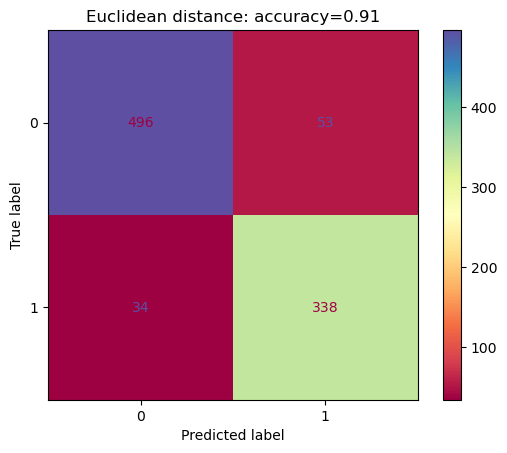

metric: Cosine by hand:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       549
           1       0.87      0.91      0.89       372

    accuracy                           0.91       921
   macro avg       0.90      0.91      0.91       921
weighted avg       0.91      0.91      0.91       921



/tmp/ipykernel_1277572/146901915.py:2: RuntimeWarning: invalid value encountered in scalar divide
  knnModel2=KNeighborsClassifier(n_neighbors=5, metric=lambda a,b: 0.5*(1-np.inner(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))) #cosine metric by hand


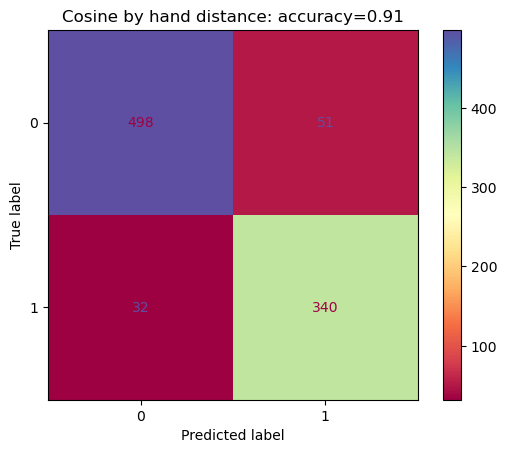

metric: Cosine by sklearn:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       549
           1       0.87      0.91      0.89       372

    accuracy                           0.91       921
   macro avg       0.90      0.91      0.91       921
weighted avg       0.91      0.91      0.91       921



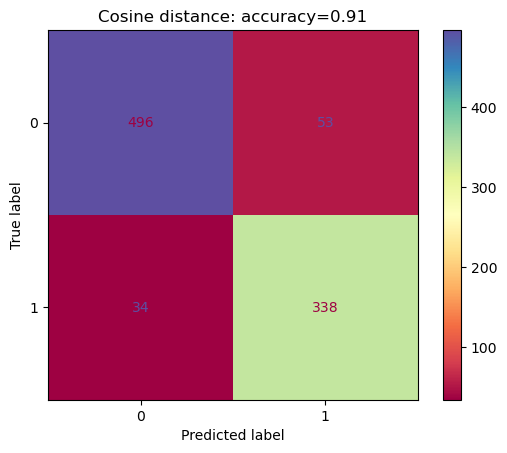

metric: Hamming
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       549
           1       0.94      0.50      0.65       372

    accuracy                           0.79       921
   macro avg       0.84      0.74      0.75       921
weighted avg       0.82      0.79      0.77       921



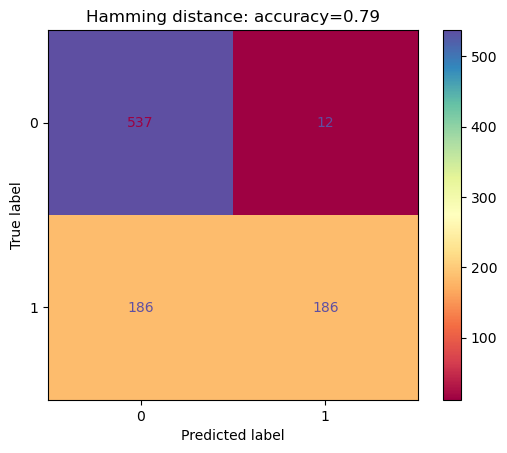

In [46]:
print("metric: Euclidean:\n"+classification_report(Ytest,yPred))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred)).plot(cmap='Spectral')
plt.title(f"Euclidean distance: accuracy={trainedKnnModel.score(Xtest,Ytest):.2f}")
plt.show()

print("metric: Cosine by hand:\n"+classification_report(Ytest,yPred2))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred2)).plot(cmap='Spectral')
plt.title(f"Cosine by hand distance: accuracy={trainedKnnModel2.score(Xtest,Ytest):.2f}")
plt.show()

print("metric: Cosine by sklearn:\n"+classification_report(Ytest,yPred3))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred)).plot(cmap='Spectral')
plt.title(f"Cosine distance: accuracy={trainedKnnModel3.score(Xtest,Ytest):.2f}")
plt.show()

print("metric: Hamming\n"+classification_report(Ytest,yPred4))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred4)).plot(cmap='Spectral')
plt.title(f"Hamming distance: accuracy={trainedKnnModel4.score(Xtest,Ytest):.2f}")
plt.show()

## Analysis of results and moving to TF-IDF
We note that for the `spambase` data using TF both Euclidean and cosine metrics are above 90%.

Let us construct the TF-IDF values and try the above methods on the same data (same split into train and test set, because we set the `random_state` variable to the same number.)

metric: Euclidean:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       549
           1       0.89      0.91      0.90       372

    accuracy                           0.92       921
   macro avg       0.91      0.92      0.92       921
weighted avg       0.92      0.92      0.92       921



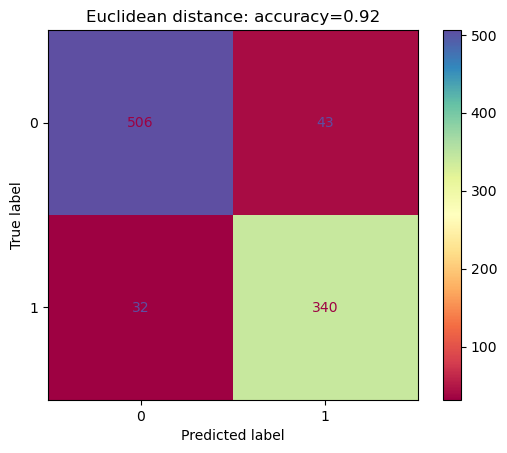

metric: Cosine by sklearn:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       549
           1       0.87      0.90      0.88       372

    accuracy                           0.90       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.91      0.90      0.90       921



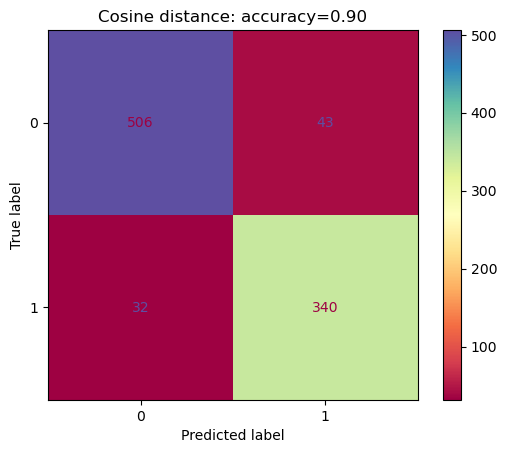

metric: Hamming
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       549
           1       0.94      0.50      0.65       372

    accuracy                           0.79       921
   macro avg       0.84      0.74      0.75       921
weighted avg       0.82      0.79      0.77       921



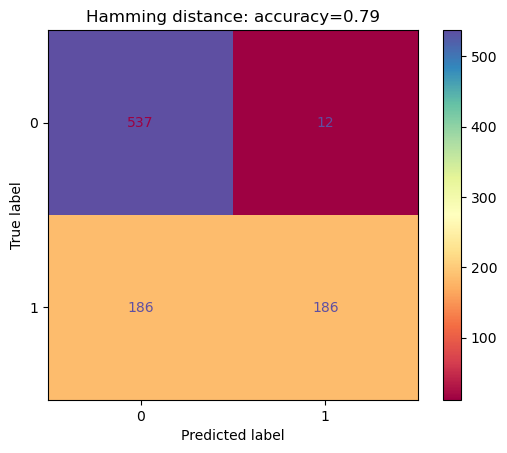

In [50]:
XTrainA,XtestA,yTrainA,YtestA = train_test_split(spamDatDf[spamDatDf.columns[:-3]]*idf(spamDatDf[spamDatDf.columns[:-3]]),spamDat['target'], test_size=0.2, random_state=20)
knnModelA=KNeighborsClassifier(n_neighbors=5) #if metric not specified, Euclidean is used
knnModelA3=KNeighborsClassifier(n_neighbors=5,metric='cosine') # cosine metric provided by sklearn
knnModelA4=KNeighborsClassifier(n_neighbors=5,metric='hamming') # cosine metric provided by sklearn
trainedKnnModelA=knnModelA.fit(XTrainA,yTrainA)
trainedKnnModelA3=knnModelA3.fit(XTrainA,yTrainA)
trainedKnnModelA4=knnModelA4.fit(XTrainA,yTrainA)

yPredA=trainedKnnModelA.predict(XtestA)
yPredA_p=trainedKnnModelA.predict_proba(XtestA)
yPred3A=trainedKnnModelA3.predict(XtestA)
yPredA_p3=trainedKnnModelA3.predict_proba(XtestA)
yPred4A=trainedKnnModelA4.predict(XtestA)
yPredA_p4=trainedKnnModelA4.predict_proba(XtestA)

print("metric: Euclidean:\n"+classification_report(YtestA,yPredA))
ConfusionMatrixDisplay(confusion_matrix(YtestA,yPredA)).plot(cmap='Spectral')
plt.title(f"Euclidean distance: accuracy={trainedKnnModelA.score(XtestA,YtestA):.2f}")
plt.show()

print("metric: Cosine by sklearn:\n"+classification_report(YtestA,yPred3A))
ConfusionMatrixDisplay(confusion_matrix(YtestA,yPredA)).plot(cmap='Spectral')
plt.title(f"Cosine distance: accuracy={trainedKnnModelA3.score(XtestA,YtestA):.2f}")
plt.show()

print("metric: Hamming\n"+classification_report(YtestA,yPred4A))
ConfusionMatrixDisplay(confusion_matrix(YtestA,yPred4A)).plot(cmap='Spectral')
plt.title(f"Hamming distance: accuracy={trainedKnnModelA4.score(XtestA,YtestA):.2f}")
plt.show()

We see that adding IDF increased the accuracy of Euclidan metric slightly, but in this case reduce the accuracy of the cosine metric by a little amount. Whether zero-one, TF or TF-IDF methods work better depends largel on the dataset.

# Newsgroup classification with tf-idf method 
*Usenet* is a social media that has existed since 1970's, long before the Internet became available to broad groups of people, and long before social media as exist today were on the scene. Usenet contains tens of thousands of *news groups* where people interested in the subject would visit the site, read posts, and respond or post their own views. The API works similarly to e-mail, except that what you send is readable to all, and not just the person you are sending the message to.

The `sklearn` module has a dataset that collects posts from a certain period of time in twenty different newsgroups. Our goal here is to process this dataset, tokenize it using TF-IDF method, as well as simple binary classification, and build a $k$NN model that predicts which of these twenty groups a new post would belong too. This is a good exercise in text processing and learning by text example.

In [59]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

## Load the data train set, and also generate the set of twenty group names

In [57]:
groupNames=set(fetch_20newsgroups(subset='all').target_names)
_=fetch_20newsgroups(subset='train',shuffle=True,random_state=42,)


## Remove headers 
We should remove the header information of each post which often include what newsgroup it is coming form. Also we remove the quoted messages in responses which again may have information about the newsgroup.

In [63]:
newsgroupDat = fetch_20newsgroups(subset='all', remove=("headers", "footers", "quotes"))


Set the feature and target values. Also, extract the target labels (that is newsgroup names.)

In [66]:
X_allDatList=newsgroupDat.data
y_allDatList=newsgroupDat.target
target_names=newsgroupDat.target_names
print(len(newsgroupDat.data))
print(newsgroupDat.data[0], newsgroupDat.target_names[newsgroupDat.target[0]])

18846


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!

 rec.sport.hockey


See how long the dataset is in terms of number of words, and also how many distinct words are in the data set:

In [83]:
#print(X_allDatList[0].split(), len(X_allDatList[0].split()))
blank=' '
print(f"Nnumber of distinct words after preprocessing: {len(set((blank.join(X_allDatList)).split()))}\nTotal number of words in all document: {len((blank.join(X_allDatList)).split())}")

Nnumber of distinct words after preprocessing: 288723
Total number of words in all document: 3423145


## Tokenize the dataset
Using `TfidfVectorizer` method from `sklearn` build a sparse matrix representation of the text data's TF-IDF tokens.

(Run the `?TfidfVectorizer` statement and carefully read the documentation of this function.

In [86]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
X = vectorizer.fit_transform(X_allDatList)
duration_train = time() - t0
print(f"{duration_train=:.3f}")

duration_train=1.765


Split to train and test sets:

In [89]:
XTrain,Xtest,yTrain,Ytest = train_test_split(X, y_allDatList, test_size=0.2,random_state=20)


In [91]:
XTrain.shape,Xtest.shape

((15076, 24164), (3770, 24164))

## Build $k$NN models
We build three $k$NN models for $k=5$, using $\ell_2$, "city-block" and cosine metrics:

In [94]:
knnModelGp20=KNeighborsClassifier(n_neighbors=5)
knnModel3Gp20=KNeighborsClassifier(n_neighbors=5,metric='cosine') # cosine metric provided by sklearn
knnModel4Gp20=KNeighborsClassifier(n_neighbors=5,metric='cityblock') # cosine metric provided by sklearn

trainedKnnModelGp20=knnModelGp20.fit(XTrain,yTrain)
trainedKnnModel3Gp20=knnModel3Gp20.fit(XTrain,yTrain)
trainedKnnModel4Gp20=knnModel4Gp20.fit(XTrain,yTrain)

## Run prediction and print results

In [97]:
yPredGp20=trainedKnnModelGp20.predict(Xtest)
yPred_pGp20=trainedKnnModelGp20.predict_proba(Xtest)
yPred3Gp20=trainedKnnModel3Gp20.predict(Xtest)
yPred_p3Gp20=trainedKnnModel3Gp20.predict_proba(Xtest)
yPred4Gp20=trainedKnnModel4Gp20.predict(Xtest)
yPred_p4Gp20=trainedKnnModel4Gp20.predict_proba(Xtest)

metric: Euclidean by sklearn:
              precision    recall  f1-score   support

           0       0.07      0.25      0.10       135
           1       0.10      0.23      0.14       186
           2       0.08      0.22      0.12       211
           3       0.11      0.11      0.11       187
           4       0.08      0.13      0.10       204
           5       0.20      0.08      0.12       197
           6       0.20      0.09      0.13       211
           7       0.06      0.11      0.08       176
           8       0.10      0.05      0.07       209
           9       0.06      0.06      0.06       194
          10       0.19      0.10      0.13       194
          11       0.10      0.09      0.09       205
          12       0.15      0.08      0.10       195
          13       0.25      0.15      0.19       209
          14       0.13      0.07      0.09       211
          15       0.07      0.02      0.03       199
          16       0.10      0.02      0.03       1

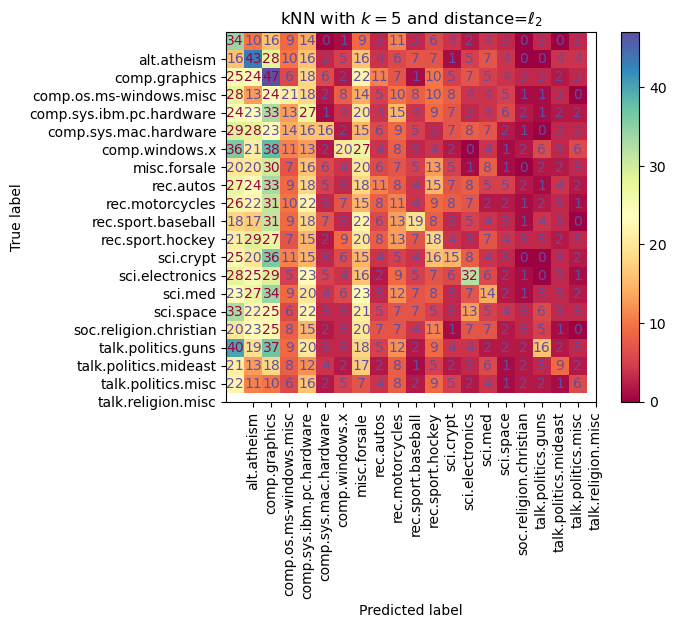

/home/farid/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/farid/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/farid/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


metric cityblock:
              precision    recall  f1-score   support

           0       0.57      0.03      0.06       135
           1       0.75      0.03      0.06       186
           2       0.83      0.02      0.05       211
           3       0.50      0.02      0.03       187
           4       0.86      0.03      0.06       204
           5       1.00      0.08      0.14       197
           6       0.06      0.99      0.11       211
           7       0.00      0.00      0.00       176
           8       0.00      0.00      0.00       209
           9       0.00      0.00      0.00       194
          10       1.00      0.01      0.01       194
          11       0.00      0.00      0.00       205
          12       0.00      0.00      0.00       195
          13       0.60      0.01      0.03       209
          14       1.00      0.00      0.01       211
          15       0.00      0.00      0.00       199
          16       0.00      0.00      0.00       171
         

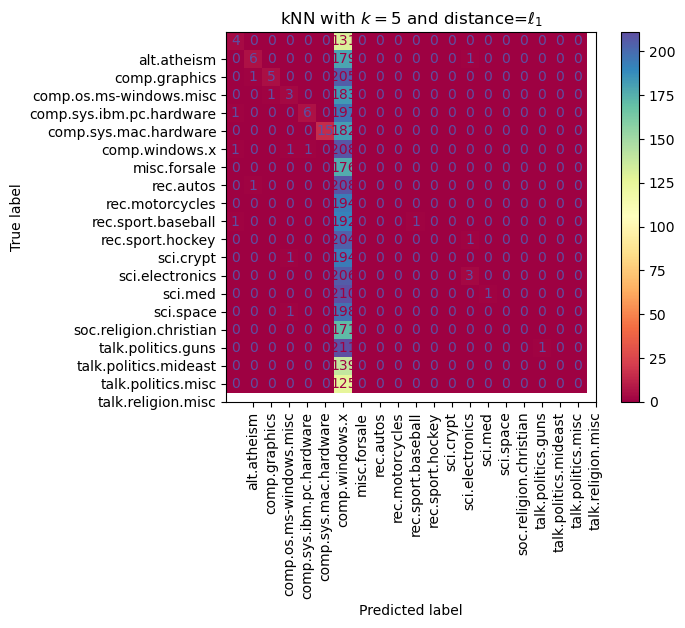

metric: Cosine by sklearn:
              precision    recall  f1-score   support

           0       0.30      0.73      0.43       135
           1       0.54      0.76      0.63       186
           2       0.57      0.68      0.62       211
           3       0.56      0.65      0.60       187
           4       0.69      0.69      0.69       204
           5       0.74      0.80      0.77       197
           6       0.70      0.63      0.66       211
           7       0.66      0.67      0.66       176
           8       0.77      0.70      0.73       209
           9       0.80      0.82      0.81       194
          10       0.83      0.88      0.85       194
          11       0.89      0.81      0.85       205
          12       0.76      0.54      0.63       195
          13       0.93      0.78      0.85       209
          14       0.90      0.65      0.76       211
          15       0.77      0.74      0.76       199
          16       0.77      0.59      0.67       171


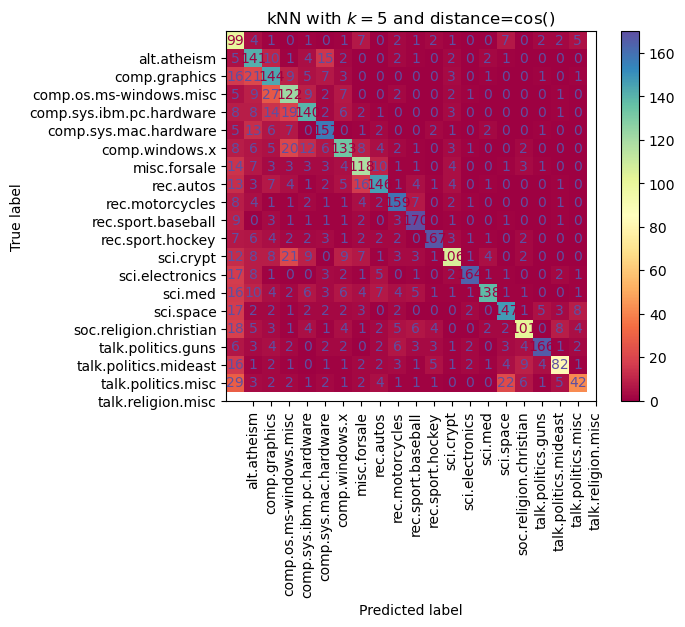

In [99]:
print("metric: Euclidean by sklearn:\n"+classification_report(Ytest,yPredGp20))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPredGp20)).plot(cmap='Spectral')
plt.xticks(ticks=range(1,21),labels=target_names,rotation=90)
plt.yticks(ticks=range(1,21),labels=target_names)
plt.title(r"kNN with $k=5$ and distance=$\ell_2$")
plt.show()

#print("Cosine by by hand:\n"+classification_report(Ytest,yPred2Gp20))
print("metric cityblock:\n"+classification_report(Ytest,yPred4Gp20))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred4Gp20)).plot(cmap='Spectral')
plt.xticks(ticks=range(1,21),labels=target_names,rotation=90)
plt.yticks(ticks=range(1,21),labels=target_names)
plt.title(r"kNN with $k=5$ and distance=$\ell_1$")
plt.show()

print("metric: Cosine by sklearn:\n"+classification_report(Ytest,yPred3Gp20))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred3Gp20)).plot(cmap='Spectral')
plt.xticks(ticks=range(1,21),labels=target_names,rotation=90)
plt.yticks(ticks=range(1,21),labels=target_names)
plt.title(r"kNN with $k=5$ and distance=$\cos()$")
plt.show()


## Discussion of results:
We see that, unlike the `spambase` data the results of the Euclidean metric are very poor, while the results of cosine metric is respectable.

## Testing the random forset approach

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfModel=RandomForestClassifier(n_estimators=500,oob_score=True,verbose=2)
model=rfModel.fit(XTrain,yTrain)

In [ ]:
yPredRF=rfModel.predict(Xtest)
yPredPRF=rfModel.predict_proba(Xtest)

In [ ]:
print("Random forest\n"+classification_report(Ytest,yPredRF))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPredRF)).plot(cmap='Spectral')
plt.xticks(ticks=range(1,21),labels=target_names,rotation=90)
plt.yticks(ticks=range(1,21),labels=target_names)
plt.title(r"Random forest with 100 tree ensemble")
plt.show()

## Working on the binary newsgroup dataset 

Now we use the `TfidfVectorizer` module to create a binary table for the 20 Usenet groups. We then use the 5NN method on this sparse binary dataset with the cosine distance

In [ ]:
vectorizer01 = TfidfVectorizer(use_idf=False, binary=True, norm=None,max_df=0.5, min_df=5, stop_words="english")
X01 = vectorizer01.fit_transform(X_allDatList)
XTrain01,Xtest01,yTrain01,Ytest01 = train_test_split(X01, y_allDatList, test_size=0.2,random_state=20)
print(f"{XTrain.shape=}, {XTrain01.shape=}, {Xtest.shape=}, {Xtest01.shape=}") 

In [ ]:
knnModel301Gp20=KNeighborsClassifier(n_neighbors=5,metric='cosine') # cosine metric provided by sklearn
trainedKnnModel301Gp20=knnModel301Gp20.fit(XTrain01,yTrain01)
yPred301Gp20=trainedKnnModel301Gp20.predict(Xtest01)
yPred_p301Gp20=trainedKnnModel301Gp20.predict_proba(Xtest01)


In [ ]:
print("metric: Cosine by sklearn:\n"+classification_report(Ytest01,yPred301Gp20))
ConfusionMatrixDisplay(confusion_matrix(Ytest,yPred301Gp20)).plot(cmap='Spectral')
plt.xticks(ticks=range(1,21),labels=target_names,rotation=90)
plt.yticks(ticks=range(1,21),labels=target_names)
plt.title(r"kNN on 0-1 data with $k=5$ and distance=$\cos()$")
plt.show()

In [ ]:
m=3
idx=np.random.randint(0,Xtest.shape[0], m)
idx
for i in idx:
    print(vectorizer.build_tokenizer()(Xtest[i]))
    print(f"Class in data: {Ytest[i]}\nPredicted class: {yPredRF[i]}")

In [ ]:
from scipy import sparse
#XTrain01[:2,:2
XTrain01.data[2], XTrain.data[2]

#?sparse._csr.csr_matrix